In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [13]:
lab_results = pd.read_csv("bt_dir_finding_lab_results.csv")
lab_results.head()

,x,y,z,measured_azimuth,measured_elevation
0,0.00,0.00,0.0,-5,-1
1,4.99,0.00,0.0,40,-30
2,10.20,0.00,0.0,-50,0
3,13.30,0.00,0.0,-50,-30
4,0.00,4.02,0.0,-5,36


In [17]:
lab_results["expected_azimuth"] = np.rad2deg(
    np.arctan2(lab_results["x"], lab_results["y"])
)
lab_results["expected_elevation"] = np.rad2deg(
    np.arctan2(lab_results["z"], np.sqrt(lab_results["x"] ** 2 + lab_results["y"] ** 2))
)
lab_results.head()

,x,y,z,measured_azimuth,measured_elevation,expected_azimuth,expected_elevation
0,0.00,0.00,0.0,-5,-1,0.0,0.0
1,4.99,0.00,0.0,40,-30,90.0,0.0
2,10.20,0.00,0.0,-50,0,90.0,0.0
3,13.30,0.00,0.0,-50,-30,90.0,0.0
4,0.00,4.02,0.0,-5,36,0.0,0.0


In [18]:
lab_results["azimuth_delta"] = np.abs(
    lab_results["expected_azimuth"] - lab_results["measured_azimuth"]
)
lab_results["elevation_delta"] = np.abs(
    lab_results["expected_elevation"] - lab_results["measured_elevation"]
)
lab_results.head()

,x,y,z,measured_azimuth,measured_elevation,expected_azimuth,expected_elevation,azimuth_delta,elevation_delta
0,0.00,0.00,0.0,-5,-1,0.0,0.0,5.0,1.0
1,4.99,0.00,0.0,40,-30,90.0,0.0,50.0,30.0
2,10.20,0.00,0.0,-50,0,90.0,0.0,140.0,0.0
3,13.30,0.00,0.0,-50,-30,90.0,0.0,140.0,30.0
4,0.00,4.02,0.0,-5,36,0.0,0.0,5.0,36.0


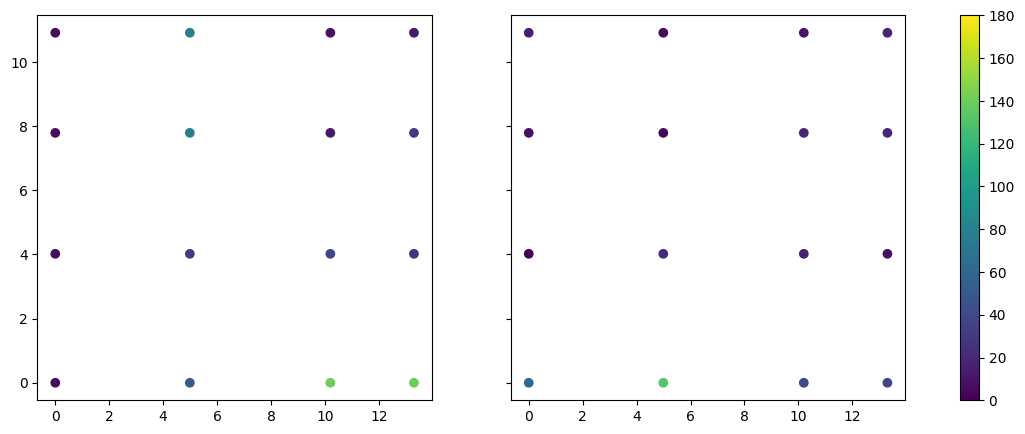

In [64]:
zeroed_target = lab_results[lab_results["z"] == 0]
elevated_target = lab_results[lab_results["z"] == -5.3]


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 5))
for i, dataset in enumerate([zeroed_target, elevated_target]):
    img = axs[i].scatter(
        zeroed_target["x"], zeroed_target["y"], c=dataset["azimuth_delta"], vmin=0, vmax=180
    )
fig.colorbar(img, ax=axs);